In [42]:
import os
import numpy as np
import math
import random
from torch.utils.data import Dataset, DataLoader
import torch
from imgaug import augmenters as iaa
from PIL import Image  # Import PIL
import cv2  # Keep cv2 for certain functions that PIL doesn't support

def warp_image(img, pts_src, pts_dst):

    # try rgb
    try:
        height, width, _ = img.shape
    # try grayscale
    except ValueError:
        height, width = img.shape

    #  Calculate Homography
    h, status = cv2.findHomography(pts_src, pts_dst)

    #  Warp source image to destination based on homography; format (4,2)
    return cv2.warpPerspective(src=img, M=h, dsize=(width, height))

class SyntheticDataset(Dataset):
    """
    Synthetic Dataset Generation for PyTorch DataLoader.
    """

    def __init__(self, input_path, background_path, target_dims=(330, 256),
                 shift=100, p=1, transform=None, grayscale=False, normalize=True):
        self.input_dir = input_path
        self.backgrounds_dir = background_path
        self.target_dims = target_dims
        self.shift = shift
        self.p = p
        self.transform = transform
        self.grayscale = grayscale
        self.normalize = normalize

        # Get list of document images and backgrounds
        self.doc_imgs = [f for f in os.listdir(self.input_dir) if self.is_image_file(f)]
        self.backgrounds = [f for f in os.listdir(self.backgrounds_dir) if self.is_image_file(f)]

        if len(self.doc_imgs) == 0:
            raise ValueError(f"No images found in input directory: {self.input_dir}")
        if len(self.backgrounds) == 0:
            raise ValueError(f"No images found in backgrounds directory: {self.backgrounds_dir}")

    def __len__(self):
        return len(self.doc_imgs) * 100  # Adjust as needed

    def __getitem__(self, idx):
        # Retrieve a random document image and background
        random_img_nm = random.choice(self.doc_imgs)
        random_background = random.choice(self.backgrounds)

        # Read and resize document image using PIL
        img_path = os.path.join(self.input_dir, random_img_nm)
        img = Image.open(img_path)
        img = img.resize((self.target_dims[1], self.target_dims[0]), Image.Resampling.LANCZOS)
        img = np.array(img)  # Convert PIL image to NumPy array

        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        if img.ndim == 2:
            img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB

        height, width, _ = img.shape

        # Augment sample
        mode = np.random.choice([0, 1], p=[self.p, 1 - self.p])
        warped_image, y = self.augment_sample(img=img, mode=mode, background=random_background)

        # Convert to grayscale if required
        if self.grayscale:
            warped_image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
            warped_image = np.expand_dims(warped_image, axis=-1)

        # Normalize
        if self.normalize:
            warped_image = warped_image.astype(np.float32) / 255.0
        else:
            warped_image = warped_image.astype(np.float32)

        # Convert image to channel-first format
        if self.grayscale:
            warped_image = np.transpose(warped_image, (2, 0, 1))  # (1, H, W)
        else:
            warped_image = np.transpose(warped_image, (2, 0, 1))  # (3, H, W)

        # Convert to torch tensors
        image_tensor = torch.tensor(warped_image, dtype=torch.float32)
        homography_tensor = torch.tensor(y, dtype=torch.float32)

        # Apply any additional transforms
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, homography_tensor

    @staticmethod
    def is_image_file(filename):
        img_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif']
        return any(filename.lower().endswith(ext) for ext in img_extensions)

    def augment_sample(self, img, mode, background):
        # Perspective transformation
        warped_image, y = self.augment_perspective(img, mode)

        # Background transformation
        background_img = self.augment_background(background)

        # Handle alpha channel if present
        if warped_image.shape[2] == 4:
            # Split alpha channel
            alpha = warped_image[:, :, 3] / 255.0
            alpha = np.expand_dims(alpha, axis=2)
            # Composite the warped image with the background
            warped_image = warped_image[:, :, :3] * alpha + background_img[:, :, :3] * (1 - alpha)
            warped_image = warped_image.astype(np.uint8)
        else:
            # If no alpha channel, assume warped_image covers the background
            warped_image = warped_image

        # Photometric transformations
        warped_image = self.augment_photometric(warped_image)

        return warped_image, y

    def augment_perspective(self, img, mode):
        # Ensure the image has an alpha channel
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
        elif img.shape[2] == 4:
            pass  # Already has alpha
        else:
            raise ValueError("Unexpected number of channels in image")

        height, width, _ = img.shape

        # Generate random offsets
        y_params = self.random_offset(height, width, mode)

        pts_src = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')
        pts_dst = y_params.reshape((4, 2)).astype('float32')

        warped_image = warp_image(img, pts_src, pts_dst)
        return warped_image, y_params

    def augment_background(self, background_filename):
        # Read background image using PIL
        background_path = os.path.join(self.backgrounds_dir, background_filename)
        background = Image.open(background_path).convert('RGB')
        background.verify()

        if background is None:
            raise FileNotFoundError(f"Background image not found: {background_path}")

        # Preprocessing: scale image if needed
        background = self.scale_image(background)

        # Convert to NumPy array
        background = np.array(background)

        # Ensure it has an alpha channel
        if background.ndim == 2:
            background = np.stack((background,)*3, axis=-1)
        if background.shape[2] == 3:
            background = cv2.cvtColor(background, cv2.COLOR_RGB2RGBA)

        # Compute random crop
        h, w, _ = background.shape
        target_h, target_w = self.target_dims
        if h < target_h or w < target_w:
            raise ValueError(f"Background image {background_filename} is smaller than target dimensions after scaling.")

        x_max, y_max = w - target_w, h - target_h
        rand_x = random.randint(0, x_max) if x_max > 0 else 0
        rand_y = random.randint(0, y_max) if y_max > 0 else 0

        # Generate random crop
        random_crop = background[rand_y:rand_y + target_h, rand_x:rand_x + target_w]
        assert(random_crop.shape[0:2] == self.target_dims), f"Crop size mismatch: {random_crop.shape[0:2]} vs {self.target_dims}"
        return random_crop

    @staticmethod
    def adjust_gamma(image, gamma=1.0):
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                          for i in np.arange(0, 256)]).astype('uint8')
        return cv2.LUT(image, table)

    def augment_photometric(self, image, sigma=(0, 1.0),
                            scale=0.05, gamma_range=(0.5, 1.5)):
        # Initialize augmenters
        augments = []
        if random.randint(0, 1) == 1:
            aug_blur = iaa.GaussianBlur(sigma=sigma)
            augments.append(aug_blur)

        if random.randint(0, 1) == 1:
            aug_noise = iaa.AdditiveGaussianNoise(scale=scale * 255)
            augments.append(aug_noise)

        # Apply augmentations sequentially
        if augments:
            seq = iaa.Sequential(augments)
            image = seq.augment_image(image)

        # Apply gamma correction
        if random.randint(0, 1) == 1:
            gamma_val = round(random.uniform(gamma_range[0], gamma_range[1]), 2)
            image = self.adjust_gamma(image, gamma=gamma_val)

        return image

    def scale_image(self, background):
        """
        Scale background image to ensure it is at least as large as target dimensions.
        """
        target_h, target_w = self.target_dims
        w, h = background.size  # Note: PIL images have size (width, height)

        if h < target_h or w < target_w:
            y_fac = target_h / h
            x_fac = target_w / w
            scalar = math.ceil(max(y_fac, x_fac))
            new_size = (int(w * scalar), int(h * scalar))
            background = background.resize(new_size, Image.Resampling.LANCZOS)

        return background

    def random_offset(self, height, width, mode=0):
        """
        Generate random offsets for perspective transformation.
        """
        if mode == 0:
            # No outliers: offsets are within [0, shift]
            tl_x, tl_y = 0 + random.randint(0, self.shift), 0 + random.randint(0, self.shift)
            tr_x, tr_y = width - random.randint(0, self.shift), 0 + random.randint(0, self.shift)
            br_x, br_y = width - random.randint(0, self.shift), height - random.randint(0, self.shift)
            bl_x, bl_y = 0 + random.randint(0, self.shift), height - random.randint(0, self.shift)
        else:
            # With outliers: offsets are within [-shift, shift]
            tl_x, tl_y = 0 + random.randint(-self.shift, self.shift), 0 + random.randint(-self.shift, self.shift)
            tr_x, tr_y = width + random.randint(-self.shift, self.shift), 0 + random.randint(-self.shift, self.shift)
            br_x, br_y = width + random.randint(-self.shift, self.shift), height + random.randint(-self.shift, self.shift)
            bl_x, bl_y = 0 + random.randint(-self.shift, self.shift), height + random.randint(-self.shift, self.shift)

        return np.array([tl_x, tl_y, tr_x, tr_y, br_x, br_y, bl_x, bl_y])

In [45]:
dataset = SyntheticDataset(
    input_path='/mnt/c/Users/teraw/Developer/homography-projects/resources/inputs',
    background_path='/mnt/c/Users/teraw/Developer/homography-projects copy/resources/indoorCVPR_09',
    target_dims=(224, 224),
    normalize=True,
    transform=None
)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True, prefetch_factor=2)

In [46]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 8]))

In [47]:
import torchvision.models as models
import torch
import torch.nn as nn

class PointEstimatorCNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), features=[64, 128, 256, 384, 512, 1024, 2048], dims=[2048], final_dim=8):
        super(PointEstimatorCNN, self).__init__()

        layers = []
        input_channels = input_shape[0]
        for output_channels in features:
            layers.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(output_channels, affine=True))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = output_channels
        
        layers.append(nn.Conv2d(input_channels, 2048, kernel_size=1, padding=1))
        self.features = nn.Sequential(*layers)
        
        self.fc = nn.Sequential(*([nn.Linear(self.get_flatten_dim(input_shape, self.features), final_dim)]))

    def get_flatten_dim(self, input_shape, features):
        x = torch.zeros(1, *input_shape)
        x = features(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [52]:
import torchvision.models as models
import torch
import torch.nn as nn

class PointEstimatorCNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), features=[64, 128, 256, 384, 512, 1024], dims=[2048], final_dim=8):
        """ 64 -> 128 -> 256 -> 384 -> 384 -> 512 -> 1024 -> 2048 """
        super(PointEstimatorCNN, self).__init__()

        layers = []
        input_channels = input_shape[0]
        for output_channels in features:
            layers.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(output_channels, affine=True))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = output_channels
        
        layers.append(nn.Conv2d(input_channels, 2048, kernel_size=1, padding=1))
        self.features = nn.Sequential(*layers)
        
        self.fc = nn.Sequential(*([nn.Linear(self.get_flatten_dim(input_shape, self.features), final_dim)]))

    def get_flatten_dim(self, input_shape, features):
        x = torch.zeros(1, *input_shape)
        x = features(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [48]:
# model = PointEstimatorCNN(input_shape=(3, 768, 768))
# model

In [49]:
# model(images).shape

In [56]:
!pip install gradio

INFO: pip is looking at multiple versions of gradio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 7.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0


In [50]:
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error

def plot_metrics(train_losses, test_losses, train_mdes, test_mdes):
    # Plot training and testing losses
    plt.figure(figsize=(10, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # MDE plot
    plt.subplot(1, 2, 2)
    plt.plot(train_mdes, label='Train MDE')
    plt.plot(test_mdes, label='Test MDE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Displacement Error')
    plt.title('Training and Testing MDE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def mean_displacement_error(pred_points, gt_points):
    # Calculate Euclidean distances between predicted and ground truth points
    distances = torch.sqrt(((pred_points - gt_points) ** 2).sum(dim=-1))
    # Return the mean displacement error
    return distances.mean().item()  

def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    # Move model to the appropriate device (CPU or GPU)
    model = model.to(device)
    
    print("🤖Training on", device)
    best_loss = float('inf')  # initialize best loss
    best_mde = float('inf')   # initialize best mean displacement error

    # Lists to store losses and MDEs
    train_losses = []
    test_losses = []
    train_mdes = []
    test_mdes = []

    for epoch in range(epochs):
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_mde = 0.0

        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for inputs, targets in train_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()
            outputs = model(inputs)

            # Compute the loss
            loss = loss_fn(outputs, targets)
            train_loss += loss.item() / len(train_loader)

            # Compute the mean displacement error (MDE)
            mde = mean_displacement_error(outputs, targets)
            train_mde += mde / len(train_loader)

            loss.backward()
            opt.step()

            # Track current loss and MDE on progress bar
            train_bar.set_postfix(current_loss=loss.item(), current_mde=mde, best_loss=best_loss, best_mde=best_mde)

        train_losses.append(train_loss)
        train_mdes.append(train_mde)

        # Testing phase
        model.eval()
        test_loss = 0.0
        test_mde = 0.0

        test_bar = tqdm(test_loader, desc=f'📄Testing  Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        with torch.no_grad():
            for inputs, targets in test_bar:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                # Compute the loss
                loss = loss_fn(outputs, targets)
                test_loss += loss.item() / len(test_loader)

                # Compute the mean displacement error (MDE)
                mde = mean_displacement_error(outputs, targets)
                test_mde += mde / len(test_loader)

                # Track current loss and MDE on progress bar
                test_bar.set_postfix(current_loss=loss.item(), current_mde=mde, best_loss=best_loss, best_mde=best_mde)

        test_losses.append(test_loss)
        test_mdes.append(test_mde)

        # Check if test loss or test MDE is the best and save the model if either improves
        if test_mde < best_mde:
            best_mde = test_mde
            if checkpoint_path:
                checkpoint_file = f'{checkpoint_path}/best_mde_{best_mde:.4f}_epoch{epoch}.pth'
                torch.save(model.state_dict(), checkpoint_file)
                print(f'New best model saved to {checkpoint_file} with test MDE: {best_mde:.4f}')

        if test_loss < best_loss:
            best_loss = test_loss
            
            if checkpoint_path:
                checkpoint_file = f'{checkpoint_path}/best_loss_{best_loss:.4f}_epoch{epoch}.pth'
                torch.save(model.state_dict(), checkpoint_file)
                print(f'New best model saved to {checkpoint_file} with test loss: {best_loss:.4f}')
        
        print(f'⛳ Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train MDE: {train_mde:.4f} - Test Loss: {test_loss:.4f}, Test MDE: {test_mde:.4f}, Best MDE: {best_mde:.4f}')

    # Plot losses and MDEs after training
    plot_metrics(train_losses, test_losses, train_mdes, test_mdes)

🤖Training on cuda:0


📄Testing  Epoch [1/50]: 100%|██████████| 188/188 [00:43<00:00,  4.34batch/s, best_loss=inf, best_mde=inf, current_loss=13.1, current_mde=45.1]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_40.8821_epoch0.pth with test MDE: 40.8821
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_11.7872_epoch0.pth with test loss: 11.7872
⛳ Epoch 1/50 - Train Loss: 18.4730, Train MDE: 62.7748 - Test Loss: 11.7872, Test MDE: 40.8821, Best MDE: 40.8821


📄Testing  Epoch [2/50]: 100%|██████████| 188/188 [00:43<00:00,  4.35batch/s, best_loss=11.8, best_mde=40.9, current_loss=7.66, current_mde=25.4]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_29.2503_epoch1.pth with test MDE: 29.2503
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_8.5544_epoch1.pth with test loss: 8.5544
⛳ Epoch 2/50 - Train Loss: 9.0495, Train MDE: 31.2197 - Test Loss: 8.5544, Test MDE: 29.2503, Best MDE: 29.2503


📄Testing  Epoch [3/50]: 100%|██████████| 188/188 [00:43<00:00,  4.35batch/s, best_loss=8.55, best_mde=29.3, current_loss=6.39, current_mde=22.4]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_19.8420_epoch2.pth with test MDE: 19.8420
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_5.6795_epoch2.pth with test loss: 5.6795
⛳ Epoch 3/50 - Train Loss: 6.4659, Train MDE: 22.4261 - Test Loss: 5.6795, Test MDE: 19.8420, Best MDE: 19.8420


📄Testing  Epoch [4/50]: 100%|██████████| 188/188 [00:42<00:00,  4.38batch/s, best_loss=5.68, best_mde=19.8, current_loss=5.55, current_mde=19.8]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_16.8286_epoch3.pth with test MDE: 16.8286
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_4.8724_epoch3.pth with test loss: 4.8724
⛳ Epoch 4/50 - Train Loss: 5.0518, Train MDE: 17.6109 - Test Loss: 4.8724, Test MDE: 16.8286, Best MDE: 16.8286


📄Testing  Epoch [5/50]: 100%|██████████| 188/188 [00:42<00:00,  4.41batch/s, best_loss=4.87, best_mde=16.8, current_loss=3.64, current_mde=12.3]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_14.2754_epoch4.pth with test MDE: 14.2754
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_4.0508_epoch4.pth with test loss: 4.0508
⛳ Epoch 5/50 - Train Loss: 4.2592, Train MDE: 14.8648 - Test Loss: 4.0508, Test MDE: 14.2754, Best MDE: 14.2754


📄Testing  Epoch [6/50]: 100%|██████████| 188/188 [00:42<00:00,  4.41batch/s, best_loss=4.05, best_mde=14.3, current_loss=3.84, current_mde=12.8]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_11.7949_epoch5.pth with test MDE: 11.7949
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_3.3769_epoch5.pth with test loss: 3.3769
⛳ Epoch 6/50 - Train Loss: 3.6914, Train MDE: 12.9130 - Test Loss: 3.3769, Test MDE: 11.7949, Best MDE: 11.7949


📄Testing  Epoch [7/50]: 100%|██████████| 188/188 [00:42<00:00,  4.40batch/s, best_loss=3.38, best_mde=11.8, current_loss=2.94, current_mde=10.1]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_10.6032_epoch6.pth with test MDE: 10.6032
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_2.9956_epoch6.pth with test loss: 2.9956
⛳ Epoch 7/50 - Train Loss: 3.3689, Train MDE: 11.7873 - Test Loss: 2.9956, Test MDE: 10.6032, Best MDE: 10.6032


📄Testing  Epoch [8/50]: 100%|██████████| 188/188 [00:43<00:00,  4.37batch/s, best_loss=3, best_mde=10.6, current_loss=3.18, current_mde=11.3]


⛳ Epoch 8/50 - Train Loss: 3.1188, Train MDE: 10.9101 - Test Loss: 3.4495, Test MDE: 12.1224, Best MDE: 10.6032


📄Testing  Epoch [9/50]: 100%|██████████| 188/188 [00:44<00:00,  4.19batch/s, best_loss=3, best_mde=10.6, current_loss=2.55, current_mde=8.63]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_9.2919_epoch8.pth with test MDE: 9.2919
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_2.6300_epoch8.pth with test loss: 2.6300
⛳ Epoch 9/50 - Train Loss: 2.9266, Train MDE: 10.2318 - Test Loss: 2.6300, Test MDE: 9.2919, Best MDE: 9.2919


📄Testing  Epoch [10/50]: 100%|██████████| 188/188 [00:42<00:00,  4.42batch/s, best_loss=2.63, best_mde=9.29, current_loss=2.65, current_mde=9.21]


⛳ Epoch 10/50 - Train Loss: 2.7742, Train MDE: 9.7059 - Test Loss: 2.8975, Test MDE: 10.2686, Best MDE: 9.2919


📄Testing  Epoch [11/50]: 100%|██████████| 188/188 [00:42<00:00,  4.42batch/s, best_loss=2.63, best_mde=9.29, current_loss=2.13, current_mde=7.5] 


⛳ Epoch 11/50 - Train Loss: 2.6274, Train MDE: 9.1892 - Test Loss: 2.8186, Test MDE: 9.9337, Best MDE: 9.2919


📄Testing  Epoch [12/50]: 100%|██████████| 188/188 [00:42<00:00,  4.42batch/s, best_loss=2.63, best_mde=9.29, current_loss=2.73, current_mde=9.77]


⛳ Epoch 12/50 - Train Loss: 2.5485, Train MDE: 8.9210 - Test Loss: 2.7582, Test MDE: 9.5979, Best MDE: 9.2919


📄Testing  Epoch [13/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=2.63, best_mde=9.29, current_loss=2.53, current_mde=8.72]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_8.1679_epoch12.pth with test MDE: 8.1679
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_2.3017_epoch12.pth with test loss: 2.3017
⛳ Epoch 13/50 - Train Loss: 2.4561, Train MDE: 8.6011 - Test Loss: 2.3017, Test MDE: 8.1679, Best MDE: 8.1679


📄Testing  Epoch [14/50]: 100%|██████████| 188/188 [00:41<00:00,  4.49batch/s, best_loss=2.3, best_mde=8.17, current_loss=1.93, current_mde=6.77]


⛳ Epoch 14/50 - Train Loss: 2.3906, Train MDE: 8.3482 - Test Loss: 2.4055, Test MDE: 8.4228, Best MDE: 8.1679


📄Testing  Epoch [15/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=2.3, best_mde=8.17, current_loss=1.67, current_mde=5.85]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_7.7788_epoch14.pth with test MDE: 7.7788
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_2.2546_epoch14.pth with test loss: 2.2546
⛳ Epoch 15/50 - Train Loss: 2.3036, Train MDE: 8.0393 - Test Loss: 2.2546, Test MDE: 7.7788, Best MDE: 7.7788


📄Testing  Epoch [16/50]: 100%|██████████| 188/188 [00:41<00:00,  4.49batch/s, best_loss=2.25, best_mde=7.78, current_loss=2.57, current_mde=9.77]


⛳ Epoch 16/50 - Train Loss: 2.2586, Train MDE: 7.8938 - Test Loss: 2.3538, Test MDE: 8.1984, Best MDE: 7.7788


📄Testing  Epoch [17/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=2.25, best_mde=7.78, current_loss=1.62, current_mde=5.53]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_6.7960_epoch16.pth with test MDE: 6.7960
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.9553_epoch16.pth with test loss: 1.9553
⛳ Epoch 17/50 - Train Loss: 2.1721, Train MDE: 7.5849 - Test Loss: 1.9553, Test MDE: 6.7960, Best MDE: 6.7960


📄Testing  Epoch [18/50]: 100%|██████████| 188/188 [00:41<00:00,  4.49batch/s, best_loss=1.96, best_mde=6.8, current_loss=2.32, current_mde=8.07]


⛳ Epoch 18/50 - Train Loss: 2.1407, Train MDE: 7.4745 - Test Loss: 2.2416, Test MDE: 7.7466, Best MDE: 6.7960


📄Testing  Epoch [19/50]: 100%|██████████| 188/188 [00:42<00:00,  4.47batch/s, best_loss=1.96, best_mde=6.8, current_loss=1.34, current_mde=4.59]


⛳ Epoch 19/50 - Train Loss: 2.0882, Train MDE: 7.2775 - Test Loss: 1.9688, Test MDE: 6.9250, Best MDE: 6.7960


📄Testing  Epoch [20/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=1.96, best_mde=6.8, current_loss=2.92, current_mde=11.2]


⛳ Epoch 20/50 - Train Loss: 2.0679, Train MDE: 7.2269 - Test Loss: 2.0776, Test MDE: 7.2959, Best MDE: 6.7960


📄Testing  Epoch [21/50]: 100%|██████████| 188/188 [00:41<00:00,  4.50batch/s, best_loss=1.96, best_mde=6.8, current_loss=2.07, current_mde=7.22]


⛳ Epoch 21/50 - Train Loss: 2.0214, Train MDE: 7.0613 - Test Loss: 2.0731, Test MDE: 7.2692, Best MDE: 6.7960


📄Testing  Epoch [22/50]: 100%|██████████| 188/188 [00:35<00:00,  5.26batch/s, best_loss=1.96, best_mde=6.8, current_loss=2.34, current_mde=8.55]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_6.6080_epoch21.pth with test MDE: 6.6080
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.8665_epoch21.pth with test loss: 1.8665
⛳ Epoch 22/50 - Train Loss: 2.0021, Train MDE: 6.9690 - Test Loss: 1.8665, Test MDE: 6.6080, Best MDE: 6.6080


📄Testing  Epoch [23/50]: 100%|██████████| 188/188 [00:35<00:00,  5.36batch/s, best_loss=1.87, best_mde=6.61, current_loss=1.83, current_mde=6.2] 


⛳ Epoch 23/50 - Train Loss: 1.9698, Train MDE: 6.8646 - Test Loss: 1.8760, Test MDE: 6.6338, Best MDE: 6.6080


📄Testing  Epoch [24/50]: 100%|██████████| 188/188 [00:35<00:00,  5.27batch/s, best_loss=1.87, best_mde=6.61, current_loss=2, current_mde=7.12]   


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_6.3014_epoch23.pth with test MDE: 6.3014
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.8007_epoch23.pth with test loss: 1.8007
⛳ Epoch 24/50 - Train Loss: 1.9343, Train MDE: 6.7401 - Test Loss: 1.8007, Test MDE: 6.3014, Best MDE: 6.3014


📄Testing  Epoch [25/50]: 100%|██████████| 188/188 [00:36<00:00,  5.16batch/s, best_loss=1.8, best_mde=6.3, current_loss=1.72, current_mde=5.95]


⛳ Epoch 25/50 - Train Loss: 1.8924, Train MDE: 6.5786 - Test Loss: 1.8575, Test MDE: 6.4492, Best MDE: 6.3014


📄Testing  Epoch [26/50]: 100%|██████████| 188/188 [00:35<00:00,  5.24batch/s, best_loss=1.8, best_mde=6.3, current_loss=1.8, current_mde=6.11] 


⛳ Epoch 26/50 - Train Loss: 1.8859, Train MDE: 6.5724 - Test Loss: 1.9898, Test MDE: 6.8161, Best MDE: 6.3014


📄Testing  Epoch [27/50]: 100%|██████████| 188/188 [00:35<00:00,  5.32batch/s, best_loss=1.8, best_mde=6.3, current_loss=2.31, current_mde=8.3] 


⛳ Epoch 27/50 - Train Loss: 1.8388, Train MDE: 6.4079 - Test Loss: 2.1786, Test MDE: 7.4794, Best MDE: 6.3014


📄Testing  Epoch [28/50]: 100%|██████████| 188/188 [00:37<00:00,  5.02batch/s, best_loss=1.8, best_mde=6.3, current_loss=2.24, current_mde=8.15]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.7905_epoch27.pth with test loss: 1.7905
⛳ Epoch 28/50 - Train Loss: 1.8459, Train MDE: 6.4266 - Test Loss: 1.7905, Test MDE: 6.3977, Best MDE: 6.3014


📄Testing  Epoch [29/50]: 100%|██████████| 188/188 [00:35<00:00,  5.30batch/s, best_loss=1.79, best_mde=6.3, current_loss=1.4, current_mde=4.75] 


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_5.9780_epoch28.pth with test MDE: 5.9780
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.7062_epoch28.pth with test loss: 1.7062
⛳ Epoch 29/50 - Train Loss: 1.8089, Train MDE: 6.2971 - Test Loss: 1.7062, Test MDE: 5.9780, Best MDE: 5.9780


📄Testing  Epoch [30/50]: 100%|██████████| 188/188 [00:38<00:00,  4.87batch/s, best_loss=1.71, best_mde=5.98, current_loss=1.94, current_mde=6.89]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_5.4168_epoch29.pth with test MDE: 5.4168
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.5419_epoch29.pth with test loss: 1.5419
⛳ Epoch 30/50 - Train Loss: 1.7876, Train MDE: 6.2290 - Test Loss: 1.5419, Test MDE: 5.4168, Best MDE: 5.4168


📄Testing  Epoch [31/50]: 100%|██████████| 188/188 [00:43<00:00,  4.29batch/s, best_loss=1.54, best_mde=5.42, current_loss=1.63, current_mde=5.32]


⛳ Epoch 31/50 - Train Loss: 1.7606, Train MDE: 6.1255 - Test Loss: 2.0087, Test MDE: 7.0717, Best MDE: 5.4168


📄Testing  Epoch [32/50]: 100%|██████████| 188/188 [00:44<00:00,  4.27batch/s, best_loss=1.54, best_mde=5.42, current_loss=1.41, current_mde=4.83]


⛳ Epoch 32/50 - Train Loss: 1.7563, Train MDE: 6.1172 - Test Loss: 1.6678, Test MDE: 5.9161, Best MDE: 5.4168


📄Testing  Epoch [33/50]: 100%|██████████| 188/188 [00:42<00:00,  4.45batch/s, best_loss=1.54, best_mde=5.42, current_loss=1.79, current_mde=5.85]


⛳ Epoch 33/50 - Train Loss: 1.7469, Train MDE: 6.0764 - Test Loss: 2.0051, Test MDE: 6.8120, Best MDE: 5.4168


📄Testing  Epoch [34/50]: 100%|██████████| 188/188 [00:42<00:00,  4.42batch/s, best_loss=1.54, best_mde=5.42, current_loss=2, current_mde=6.64]   


⛳ Epoch 34/50 - Train Loss: 1.7200, Train MDE: 5.9916 - Test Loss: 1.9887, Test MDE: 6.9488, Best MDE: 5.4168


📄Testing  Epoch [35/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=1.54, best_mde=5.42, current_loss=1.65, current_mde=5.4] 


⛳ Epoch 35/50 - Train Loss: 1.6972, Train MDE: 5.9037 - Test Loss: 1.9955, Test MDE: 6.7135, Best MDE: 5.4168


📄Testing  Epoch [36/50]: 100%|██████████| 188/188 [00:42<00:00,  4.42batch/s, best_loss=1.54, best_mde=5.42, current_loss=1.41, current_mde=5.08]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_5.0088_epoch35.pth with test MDE: 5.0088
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.4058_epoch35.pth with test loss: 1.4058
⛳ Epoch 36/50 - Train Loss: 1.6945, Train MDE: 5.8963 - Test Loss: 1.4058, Test MDE: 5.0088, Best MDE: 5.0088


📄Testing  Epoch [37/50]: 100%|██████████| 188/188 [00:42<00:00,  4.47batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.13, current_mde=4.01]


⛳ Epoch 37/50 - Train Loss: 1.6844, Train MDE: 5.8661 - Test Loss: 1.4186, Test MDE: 5.1357, Best MDE: 5.0088


📄Testing  Epoch [38/50]: 100%|██████████| 188/188 [00:42<00:00,  4.47batch/s, best_loss=1.41, best_mde=5.01, current_loss=2.02, current_mde=7.27]


⛳ Epoch 38/50 - Train Loss: 1.6735, Train MDE: 5.8093 - Test Loss: 1.7951, Test MDE: 6.2460, Best MDE: 5.0088


📄Testing  Epoch [39/50]: 100%|██████████| 188/188 [00:41<00:00,  4.49batch/s, best_loss=1.41, best_mde=5.01, current_loss=2.13, current_mde=8.23]


⛳ Epoch 39/50 - Train Loss: 1.6451, Train MDE: 5.7323 - Test Loss: 1.4632, Test MDE: 5.3061, Best MDE: 5.0088


📄Testing  Epoch [40/50]: 100%|██████████| 188/188 [00:38<00:00,  4.87batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.33, current_mde=4.87]


⛳ Epoch 40/50 - Train Loss: 1.6400, Train MDE: 5.6910 - Test Loss: 1.5174, Test MDE: 5.3038, Best MDE: 5.0088


📄Testing  Epoch [41/50]: 100%|██████████| 188/188 [00:45<00:00,  4.15batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.7, current_mde=5.99] 


⛳ Epoch 41/50 - Train Loss: 1.6361, Train MDE: 5.6938 - Test Loss: 1.6342, Test MDE: 5.7157, Best MDE: 5.0088


📄Testing  Epoch [42/50]: 100%|██████████| 188/188 [00:43<00:00,  4.29batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.57, current_mde=5.15]


⛳ Epoch 42/50 - Train Loss: 1.6174, Train MDE: 5.6242 - Test Loss: 1.6727, Test MDE: 5.7044, Best MDE: 5.0088


📄Testing  Epoch [43/50]: 100%|██████████| 188/188 [00:41<00:00,  4.50batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.85, current_mde=6.11]


⛳ Epoch 43/50 - Train Loss: 1.5818, Train MDE: 5.4892 - Test Loss: 1.7691, Test MDE: 6.0753, Best MDE: 5.0088


📄Testing  Epoch [44/50]: 100%|██████████| 188/188 [00:42<00:00,  4.43batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.34, current_mde=4.72]


⛳ Epoch 44/50 - Train Loss: 1.5960, Train MDE: 5.5590 - Test Loss: 1.5112, Test MDE: 5.4030, Best MDE: 5.0088


📄Testing  Epoch [45/50]: 100%|██████████| 188/188 [00:42<00:00,  4.44batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.84, current_mde=6.44]


⛳ Epoch 45/50 - Train Loss: 1.5668, Train MDE: 5.4489 - Test Loss: 1.7503, Test MDE: 5.9835, Best MDE: 5.0088


📄Testing  Epoch [46/50]: 100%|██████████| 188/188 [00:43<00:00,  4.36batch/s, best_loss=1.41, best_mde=5.01, current_loss=1.37, current_mde=4.92]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.3987_epoch45.pth with test loss: 1.3987
⛳ Epoch 46/50 - Train Loss: 1.5526, Train MDE: 5.3729 - Test Loss: 1.3987, Test MDE: 5.0487, Best MDE: 5.0088


📄Testing  Epoch [47/50]: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, best_loss=1.4, best_mde=5.01, current_loss=1.56, current_mde=5.2] 


⛳ Epoch 47/50 - Train Loss: 1.5528, Train MDE: 5.3871 - Test Loss: 1.7321, Test MDE: 5.8946, Best MDE: 5.0088


📄Testing  Epoch [48/50]: 100%|██████████| 188/188 [00:41<00:00,  4.49batch/s, best_loss=1.4, best_mde=5.01, current_loss=2.11, current_mde=7.06]


⛳ Epoch 48/50 - Train Loss: 1.5443, Train MDE: 5.3600 - Test Loss: 1.8903, Test MDE: 6.3955, Best MDE: 5.0088


📄Testing  Epoch [49/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=1.4, best_mde=5.01, current_loss=1.62, current_mde=5.55]


⛳ Epoch 49/50 - Train Loss: 1.5356, Train MDE: 5.3407 - Test Loss: 1.7837, Test MDE: 6.0857, Best MDE: 5.0088


📄Testing  Epoch [50/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=1.4, best_mde=5.01, current_loss=1.34, current_mde=4.61]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_mde_4.7230_epoch49.pth with test MDE: 4.7230
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/best_loss_1.3255_epoch49.pth with test loss: 1.3255
⛳ Epoch 50/50 - Train Loss: 1.5364, Train MDE: 5.3388 - Test Loss: 1.3255, Test MDE: 4.7230, Best MDE: 4.7230


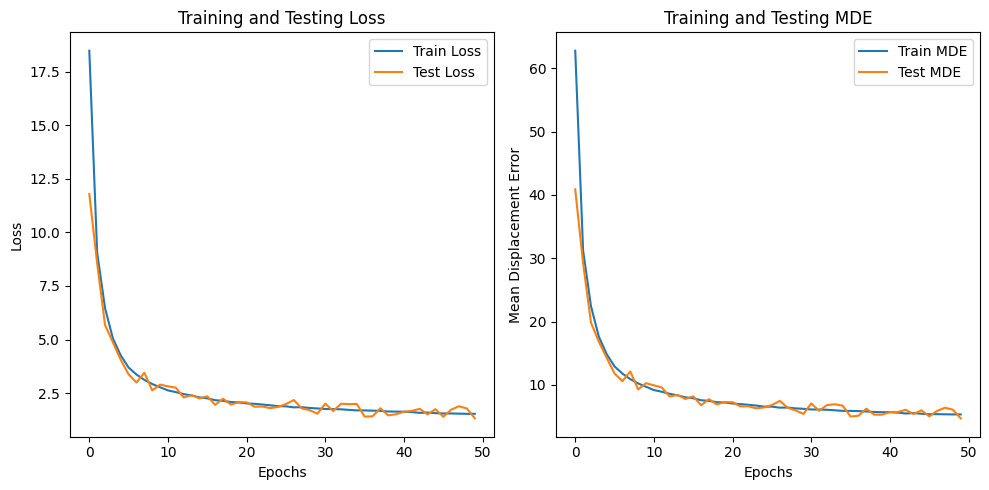

In [53]:
checkpoint_path = '/mnt/c/Users/teraw/Developer/homography-projects/cp/224'
# model = PointEstimatorCNN(input_shape=(3, 224, 224), features=[128, 256, 512], dims=[512], final_dim=8)
model = PointEstimatorCNN(input_shape=(3, 224, 224))
num_epochs = 50
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()
opt = torch.optim.RMSprop(model.parameters(), lr=0.0005,  # 0.0005 -> 0.00025 -> 0.000125 -> 0.0000625 -> ...
                          alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, capturable=False, foreach=None, maximize=False, differentiable=False)
train(model, opt, loss_fn, train_loader, test_loader, num_epochs, checkpoint_path, device='cuda:0')

🤖Training on cuda:0


📄Testing  Epoch [1/50]: 100%|██████████| 188/188 [00:35<00:00,  5.33batch/s, best_loss=inf, best_mde=inf, current_loss=1.4, current_mde=5.05]  


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.8084_epoch0.pth with test MDE: 3.8084
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_1.0652_epoch0.pth with test loss: 1.0652
⛳ Epoch 1/50 - Train Loss: 1.1196, Train MDE: 4.0051 - Test Loss: 1.0652, Test MDE: 3.8084, Best MDE: 3.8084


📄Testing  Epoch [2/50]: 100%|██████████| 188/188 [00:35<00:00,  5.32batch/s, best_loss=1.07, best_mde=3.81, current_loss=1.69, current_mde=5.96] 


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.5623_epoch1.pth with test MDE: 3.5623
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_1.0094_epoch1.pth with test loss: 1.0094
⛳ Epoch 2/50 - Train Loss: 1.0093, Train MDE: 3.6281 - Test Loss: 1.0094, Test MDE: 3.5623, Best MDE: 3.5623


📄Testing  Epoch [3/50]: 100%|██████████| 188/188 [00:45<00:00,  4.17batch/s, best_loss=1.01, best_mde=3.56, current_loss=1, current_mde=3.74]    


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.5311_epoch2.pth with test MDE: 3.5311
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.9826_epoch2.pth with test loss: 0.9826
⛳ Epoch 3/50 - Train Loss: 0.9981, Train MDE: 3.5952 - Test Loss: 0.9826, Test MDE: 3.5311, Best MDE: 3.5311


📄Testing  Epoch [4/50]: 100%|██████████| 188/188 [00:43<00:00,  4.30batch/s, best_loss=0.983, best_mde=3.53, current_loss=1.19, current_mde=4.02] 


⛳ Epoch 4/50 - Train Loss: 0.9931, Train MDE: 3.5643 - Test Loss: 1.1417, Test MDE: 3.9747, Best MDE: 3.5311


📄Testing  Epoch [5/50]: 100%|██████████| 188/188 [00:42<00:00,  4.39batch/s, best_loss=0.983, best_mde=3.53, current_loss=0.695, current_mde=2.35]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.2614_epoch4.pth with test MDE: 3.2614
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.9204_epoch4.pth with test loss: 0.9204
⛳ Epoch 5/50 - Train Loss: 0.9647, Train MDE: 3.4574 - Test Loss: 0.9204, Test MDE: 3.2614, Best MDE: 3.2614


📄Testing  Epoch [6/50]: 100%|██████████| 188/188 [00:42<00:00,  4.40batch/s, best_loss=0.92, best_mde=3.26, current_loss=1.36, current_mde=5.2]  


⛳ Epoch 6/50 - Train Loss: 0.9649, Train MDE: 3.4594 - Test Loss: 1.0659, Test MDE: 3.7491, Best MDE: 3.2614


📄Testing  Epoch [7/50]: 100%|██████████| 188/188 [00:42<00:00,  4.39batch/s, best_loss=0.92, best_mde=3.26, current_loss=1.03, current_mde=3.68] 


⛳ Epoch 7/50 - Train Loss: 0.9523, Train MDE: 3.4142 - Test Loss: 1.1581, Test MDE: 4.1541, Best MDE: 3.2614


📄Testing  Epoch [8/50]: 100%|██████████| 188/188 [00:42<00:00,  4.39batch/s, best_loss=0.92, best_mde=3.26, current_loss=1.6, current_mde=5.76]  


⛳ Epoch 8/50 - Train Loss: 0.9505, Train MDE: 3.4068 - Test Loss: 1.1441, Test MDE: 3.9779, Best MDE: 3.2614


📄Testing  Epoch [9/50]: 100%|██████████| 188/188 [00:43<00:00,  4.30batch/s, best_loss=0.92, best_mde=3.26, current_loss=0.784, current_mde=2.68]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.1747_epoch8.pth with test MDE: 3.1747
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.8763_epoch8.pth with test loss: 0.8763
⛳ Epoch 9/50 - Train Loss: 0.9493, Train MDE: 3.4056 - Test Loss: 0.8763, Test MDE: 3.1747, Best MDE: 3.1747


📄Testing  Epoch [10/50]: 100%|██████████| 188/188 [00:42<00:00,  4.37batch/s, best_loss=0.876, best_mde=3.17, current_loss=0.822, current_mde=2.91]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.1221_epoch9.pth with test MDE: 3.1221
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.8660_epoch9.pth with test loss: 0.8660
⛳ Epoch 10/50 - Train Loss: 0.9338, Train MDE: 3.3401 - Test Loss: 0.8660, Test MDE: 3.1221, Best MDE: 3.1221


📄Testing  Epoch [11/50]: 100%|██████████| 188/188 [00:45<00:00,  4.17batch/s, best_loss=0.866, best_mde=3.12, current_loss=1.12, current_mde=4.03] 


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_3.0116_epoch10.pth with test MDE: 3.0116
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.8363_epoch10.pth with test loss: 0.8363
⛳ Epoch 11/50 - Train Loss: 0.9313, Train MDE: 3.3398 - Test Loss: 0.8363, Test MDE: 3.0116, Best MDE: 3.0116


📄Testing  Epoch [12/50]: 100%|██████████| 188/188 [00:44<00:00,  4.21batch/s, best_loss=0.836, best_mde=3.01, current_loss=0.903, current_mde=3.17]


⛳ Epoch 12/50 - Train Loss: 0.9331, Train MDE: 3.3488 - Test Loss: 0.9844, Test MDE: 3.4956, Best MDE: 3.0116


📄Testing  Epoch [13/50]: 100%|██████████| 188/188 [00:44<00:00,  4.21batch/s, best_loss=0.836, best_mde=3.01, current_loss=0.989, current_mde=3.65]


⛳ Epoch 13/50 - Train Loss: 0.9444, Train MDE: 3.3916 - Test Loss: 0.9694, Test MDE: 3.4457, Best MDE: 3.0116


📄Testing  Epoch [14/50]: 100%|██████████| 188/188 [00:44<00:00,  4.26batch/s, best_loss=0.836, best_mde=3.01, current_loss=0.845, current_mde=2.93]


⛳ Epoch 14/50 - Train Loss: 0.9273, Train MDE: 3.3211 - Test Loss: 0.9552, Test MDE: 3.4103, Best MDE: 3.0116


📄Testing  Epoch [15/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.836, best_mde=3.01, current_loss=0.776, current_mde=2.8] 


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.9657_epoch14.pth with test MDE: 2.9657
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.8208_epoch14.pth with test loss: 0.8208
⛳ Epoch 15/50 - Train Loss: 0.9245, Train MDE: 3.3009 - Test Loss: 0.8208, Test MDE: 2.9657, Best MDE: 2.9657


📄Testing  Epoch [16/50]: 100%|██████████| 188/188 [00:44<00:00,  4.21batch/s, best_loss=0.821, best_mde=2.97, current_loss=0.675, current_mde=2.27]


⛳ Epoch 16/50 - Train Loss: 0.9099, Train MDE: 3.2497 - Test Loss: 0.8481, Test MDE: 3.0548, Best MDE: 2.9657


📄Testing  Epoch [17/50]: 100%|██████████| 188/188 [00:50<00:00,  3.74batch/s, best_loss=0.821, best_mde=2.97, current_loss=1.4, current_mde=4.73]  


⛳ Epoch 17/50 - Train Loss: 0.9311, Train MDE: 3.3449 - Test Loss: 1.1133, Test MDE: 3.9175, Best MDE: 2.9657


📄Testing  Epoch [18/50]: 100%|██████████| 188/188 [00:42<00:00,  4.43batch/s, best_loss=0.821, best_mde=2.97, current_loss=0.697, current_mde=2.41]


⛳ Epoch 18/50 - Train Loss: 0.9063, Train MDE: 3.2514 - Test Loss: 0.8508, Test MDE: 3.0768, Best MDE: 2.9657


📄Testing  Epoch [19/50]: 100%|██████████| 188/188 [00:42<00:00,  4.41batch/s, best_loss=0.821, best_mde=2.97, current_loss=0.803, current_mde=2.76]


⛳ Epoch 19/50 - Train Loss: 0.9216, Train MDE: 3.2953 - Test Loss: 0.8952, Test MDE: 3.2002, Best MDE: 2.9657


📄Testing  Epoch [20/50]: 100%|██████████| 188/188 [00:42<00:00,  4.38batch/s, best_loss=0.821, best_mde=2.97, current_loss=0.741, current_mde=2.48]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.8650_epoch19.pth with test MDE: 2.8650
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.7837_epoch19.pth with test loss: 0.7837
⛳ Epoch 20/50 - Train Loss: 0.9110, Train MDE: 3.2644 - Test Loss: 0.7837, Test MDE: 2.8650, Best MDE: 2.8650


📄Testing  Epoch [21/50]: 100%|██████████| 188/188 [00:41<00:00,  4.57batch/s, best_loss=0.784, best_mde=2.87, current_loss=0.907, current_mde=3.18]


⛳ Epoch 21/50 - Train Loss: 0.9074, Train MDE: 3.2440 - Test Loss: 0.8957, Test MDE: 3.2265, Best MDE: 2.8650


📄Testing  Epoch [22/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=0.784, best_mde=2.87, current_loss=0.691, current_mde=2.43]


⛳ Epoch 22/50 - Train Loss: 0.9077, Train MDE: 3.2518 - Test Loss: 0.8797, Test MDE: 3.1681, Best MDE: 2.8650


📄Testing  Epoch [23/50]: 100%|██████████| 188/188 [00:39<00:00,  4.70batch/s, best_loss=0.784, best_mde=2.87, current_loss=1.21, current_mde=4.39] 


⛳ Epoch 23/50 - Train Loss: 0.9046, Train MDE: 3.2426 - Test Loss: 0.9682, Test MDE: 3.5135, Best MDE: 2.8650


📄Testing  Epoch [24/50]: 100%|██████████| 188/188 [00:41<00:00,  4.52batch/s, best_loss=0.784, best_mde=2.87, current_loss=0.714, current_mde=2.64]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.8101_epoch23.pth with test MDE: 2.8101
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.7743_epoch23.pth with test loss: 0.7743
⛳ Epoch 24/50 - Train Loss: 0.8835, Train MDE: 3.1611 - Test Loss: 0.7743, Test MDE: 2.8101, Best MDE: 2.8101


📄Testing  Epoch [25/50]: 100%|██████████| 188/188 [00:41<00:00,  4.53batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.665, current_mde=2.22]


⛳ Epoch 25/50 - Train Loss: 0.8927, Train MDE: 3.1905 - Test Loss: 0.8261, Test MDE: 3.0065, Best MDE: 2.8101


📄Testing  Epoch [26/50]: 100%|██████████| 188/188 [00:41<00:00,  4.56batch/s, best_loss=0.774, best_mde=2.81, current_loss=1.47, current_mde=5.41] 


⛳ Epoch 26/50 - Train Loss: 0.8825, Train MDE: 3.1530 - Test Loss: 0.8887, Test MDE: 3.2193, Best MDE: 2.8101


📄Testing  Epoch [27/50]: 100%|██████████| 188/188 [00:42<00:00,  4.43batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.725, current_mde=2.58]


⛳ Epoch 27/50 - Train Loss: 0.8694, Train MDE: 3.1100 - Test Loss: 0.8634, Test MDE: 3.0645, Best MDE: 2.8101


📄Testing  Epoch [28/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.852, current_mde=2.99]


⛳ Epoch 28/50 - Train Loss: 0.8874, Train MDE: 3.1713 - Test Loss: 0.9124, Test MDE: 3.2531, Best MDE: 2.8101


📄Testing  Epoch [29/50]: 100%|██████████| 188/188 [00:44<00:00,  4.22batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.702, current_mde=2.48]


⛳ Epoch 29/50 - Train Loss: 0.8814, Train MDE: 3.1479 - Test Loss: 0.8330, Test MDE: 2.9863, Best MDE: 2.8101


📄Testing  Epoch [30/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.745, current_mde=2.7] 


⛳ Epoch 30/50 - Train Loss: 0.8746, Train MDE: 3.1303 - Test Loss: 0.8329, Test MDE: 3.0002, Best MDE: 2.8101


📄Testing  Epoch [31/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.774, best_mde=2.81, current_loss=0.687, current_mde=2.38]


⛳ Epoch 31/50 - Train Loss: 0.8827, Train MDE: 3.1589 - Test Loss: 0.8598, Test MDE: 3.0371, Best MDE: 2.8101


📄Testing  Epoch [32/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.774, best_mde=2.81, current_loss=1.07, current_mde=3.62] 


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.5848_epoch31.pth with test MDE: 2.5848
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.7193_epoch31.pth with test loss: 0.7193
⛳ Epoch 32/50 - Train Loss: 0.8877, Train MDE: 3.1809 - Test Loss: 0.7193, Test MDE: 2.5848, Best MDE: 2.5848


📄Testing  Epoch [33/50]: 100%|██████████| 188/188 [00:44<00:00,  4.22batch/s, best_loss=0.719, best_mde=2.58, current_loss=0.705, current_mde=2.43]


⛳ Epoch 33/50 - Train Loss: 0.8844, Train MDE: 3.1758 - Test Loss: 0.9413, Test MDE: 3.4420, Best MDE: 2.5848


📄Testing  Epoch [34/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.719, best_mde=2.58, current_loss=0.716, current_mde=2.47]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.5694_epoch33.pth with test MDE: 2.5694
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.7085_epoch33.pth with test loss: 0.7085
⛳ Epoch 34/50 - Train Loss: 0.8792, Train MDE: 3.1473 - Test Loss: 0.7085, Test MDE: 2.5694, Best MDE: 2.5694


📄Testing  Epoch [35/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.651, current_mde=2.2] 


⛳ Epoch 35/50 - Train Loss: 0.8581, Train MDE: 3.0526 - Test Loss: 0.8737, Test MDE: 3.0945, Best MDE: 2.5694


📄Testing  Epoch [36/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.647, current_mde=2.22]


⛳ Epoch 36/50 - Train Loss: 0.8790, Train MDE: 3.1619 - Test Loss: 0.7630, Test MDE: 2.7481, Best MDE: 2.5694


📄Testing  Epoch [37/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.651, current_mde=2.31]


⛳ Epoch 37/50 - Train Loss: 0.8644, Train MDE: 3.0868 - Test Loss: 0.8410, Test MDE: 3.0414, Best MDE: 2.5694


📄Testing  Epoch [38/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=1.37, current_mde=6.42] 


⛳ Epoch 38/50 - Train Loss: 0.8670, Train MDE: 3.1034 - Test Loss: 0.7844, Test MDE: 2.8549, Best MDE: 2.5694


📄Testing  Epoch [39/50]: 100%|██████████| 188/188 [00:44<00:00,  4.22batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.734, current_mde=2.67]


⛳ Epoch 39/50 - Train Loss: 0.8604, Train MDE: 3.0839 - Test Loss: 0.8581, Test MDE: 3.1285, Best MDE: 2.5694


📄Testing  Epoch [40/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.651, current_mde=2.24]


⛳ Epoch 40/50 - Train Loss: 0.8576, Train MDE: 3.0611 - Test Loss: 0.8617, Test MDE: 3.0895, Best MDE: 2.5694


📄Testing  Epoch [41/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.794, current_mde=2.87]


⛳ Epoch 41/50 - Train Loss: 0.8595, Train MDE: 3.0744 - Test Loss: 0.9099, Test MDE: 3.2272, Best MDE: 2.5694


📄Testing  Epoch [42/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.617, current_mde=2.17]


⛳ Epoch 42/50 - Train Loss: 0.8648, Train MDE: 3.0942 - Test Loss: 0.8374, Test MDE: 3.0148, Best MDE: 2.5694


📄Testing  Epoch [43/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.787, current_mde=2.81]


⛳ Epoch 43/50 - Train Loss: 0.8516, Train MDE: 3.0327 - Test Loss: 0.8429, Test MDE: 2.9968, Best MDE: 2.5694


📄Testing  Epoch [44/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=1.23, current_mde=4.84] 


⛳ Epoch 44/50 - Train Loss: 0.8509, Train MDE: 3.0409 - Test Loss: 0.9564, Test MDE: 3.3375, Best MDE: 2.5694


📄Testing  Epoch [45/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.613, current_mde=2.29]


⛳ Epoch 45/50 - Train Loss: 0.8640, Train MDE: 3.0864 - Test Loss: 0.8049, Test MDE: 2.9468, Best MDE: 2.5694


📄Testing  Epoch [46/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.657, current_mde=2.18]


⛳ Epoch 46/50 - Train Loss: 0.8426, Train MDE: 3.0093 - Test Loss: 0.7858, Test MDE: 2.8271, Best MDE: 2.5694


📄Testing  Epoch [47/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.709, best_mde=2.57, current_loss=0.618, current_mde=2.11]


New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_mde_2.5409_epoch46.pth with test MDE: 2.5409
New best model saved to /mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2/best_loss_0.6985_epoch46.pth with test loss: 0.6985
⛳ Epoch 47/50 - Train Loss: 0.8353, Train MDE: 2.9816 - Test Loss: 0.6985, Test MDE: 2.5409, Best MDE: 2.5409


📄Testing  Epoch [48/50]: 100%|██████████| 188/188 [00:44<00:00,  4.23batch/s, best_loss=0.698, best_mde=2.54, current_loss=0.649, current_mde=2.19]


⛳ Epoch 48/50 - Train Loss: 0.8328, Train MDE: 2.9543 - Test Loss: 0.7763, Test MDE: 2.7978, Best MDE: 2.5409


📄Testing  Epoch [49/50]: 100%|██████████| 188/188 [00:44<00:00,  4.25batch/s, best_loss=0.698, best_mde=2.54, current_loss=1.91, current_mde=6.81] 


⛳ Epoch 49/50 - Train Loss: 0.8437, Train MDE: 3.0153 - Test Loss: 0.9048, Test MDE: 3.2011, Best MDE: 2.5409


📄Testing  Epoch [50/50]: 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s, best_loss=0.698, best_mde=2.54, current_loss=1.22, current_mde=4.4]  


⛳ Epoch 50/50 - Train Loss: 0.8339, Train MDE: 2.9737 - Test Loss: 0.9376, Test MDE: 3.3301, Best MDE: 2.5409


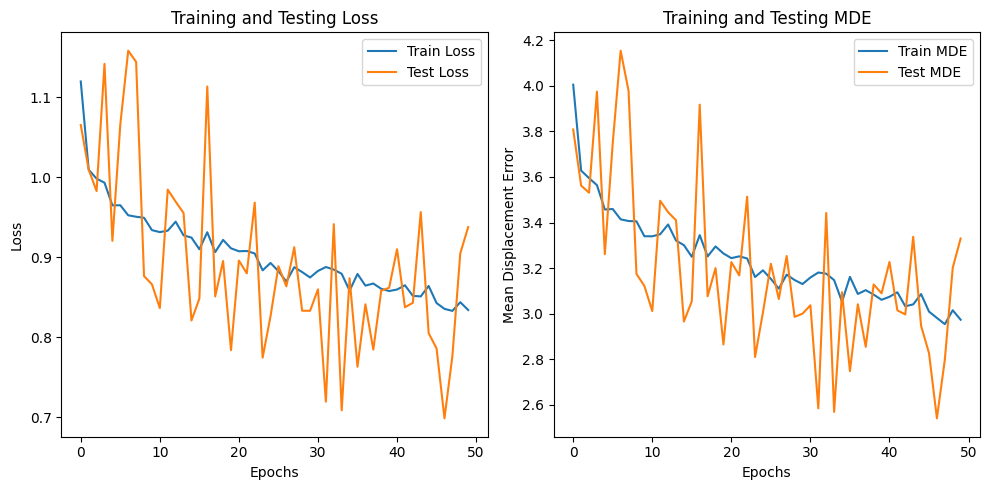

In [54]:
checkpoint_path = '/mnt/c/Users/teraw/Developer/homography-projects/cp/224/p2'

opt = torch.optim.RMSprop(model.parameters(), lr=0.00025,  # 0.0005 -> 0.00025 -> 0.000125 -> 0.0000625 -> ...
                          alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, capturable=False, foreach=None, maximize=False, differentiable=False)
train(model, opt, loss_fn, train_loader, test_loader, num_epochs, checkpoint_path, device='cuda:0')

In [7]:
model = PointEstimatorCNN()
model.load_state_dict(torch.load('/home/teerawat.c/homography-projects/cp/0.5227_epoch39.pth'))

/tmp/ipykernel_2474697/3635317001.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/teerawat.c/homography-projects/cp/0.5227_epoch3

<All keys matched successfully>

In [25]:
images[1, :, :, :].shape

torch.Size([3, 224, 224])

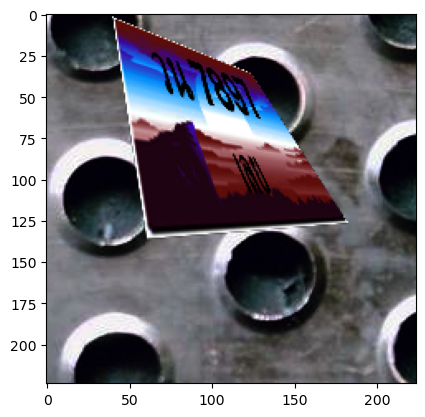

In [35]:
import matplotlib.pyplot as plot
sample = images[1, :, :, :].unsqueeze(dim=0)
plot.imshow(sample.squeeze().numpy().transpose(1, 2, 0))

In [29]:
predict = model(sample)

array([[ 40.51734  ,   3.0318532],
       [124.11783  ,  36.831562 ],
       [183.32396  , 127.9218   ],
       [ 61.102234 , 137.07893  ]], dtype=float32)

In [31]:
import numpy as np
import cv2

def find_homography(src_pts, dst_pts):
  """
  Calculates the homography matrix between two sets of corresponding points.

  Args:
    src_pts: Source points (Nx2 array).
    dst_pts: Destination points (Nx2 array).

  Returns:
    The homography matrix (3x3 array).
  """

  assert src_pts.shape == dst_pts.shape and src_pts.shape[0] >= 4

  A = []
  for i in range(src_pts.shape[0]):
    x, y = src_pts[i]
    u, v = dst_pts[i]
    A.append([x, y, 1, 0, 0, 0, -u * x, -u * y, -u])
    A.append([0, 0, 0, x, y, 1, -v * x, -v * y, -v])

  A = np.array(A)
  _, _, V = np.linalg.svd(A)
  H = V[-1, :].reshape((3, 3))
  H = H / H[2, 2] 

  return H


def apply_homography(image, H):
  """
  Applies a homography transformation to an image.

  Args:
    image: The input image.
    H: The homography matrix.

  Returns:
    The transformed image.
  """

  rows, cols = image.shape[:2]
  new_corners = np.array([[0, 0], [cols - 1, 0], [cols - 1, rows - 1], [0, rows - 1]])
  transformed_corners = cv2.perspectiveTransform(np.array([new_corners]).astype(np.float32), H)
  min_x = np.min(transformed_corners[:, :, 0])
  max_x = np.max(transformed_corners[:, :, 0])
  min_y = np.min(transformed_corners[:, :, 1])
  max_y = np.max(transformed_corners[:, :, 1])

  transformed_image = cv2.warpPerspective(image, H, (int(max_x - min_x), int(max_y - min_y)))
  return transformed_image

def warpPerspective(img, H, output_shape):
    """
    Applies a perspective transformation to an image using a homography matrix with optimized performance.

    Args:
        img: The input image (numpy array).
        H: The 3x3 homography matrix.
        output_shape: The desired shape of the output image (height, width).

    Returns:
        The warped image (numpy array).
    """
    height, width = output_shape

    # Create a grid of (x, y) coordinates in the output image
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # Stack and reshape to form homogeneous coordinates (x, y, 1)
    homogeneous_coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()], axis=1)

    # Apply the inverse homography matrix to the coordinates
    src_coords = np.dot(homogeneous_coords, np.linalg.inv(H).T)

    # Normalize homogeneous coordinates to get (x, y)
    src_coords /= src_coords[:, 2][:, np.newaxis]

    # Clip the coordinates to ensure they are within image bounds
    src_x = np.clip(src_coords[:, 0].astype(np.int32), 0, img.shape[1] - 1)
    src_y = np.clip(src_coords[:, 1].astype(np.int32), 0, img.shape[0] - 1)

    # Reshape back to the output image shape
    warped_img = img[src_y, src_x].reshape(height, width, img.shape[2])

    return warped_img

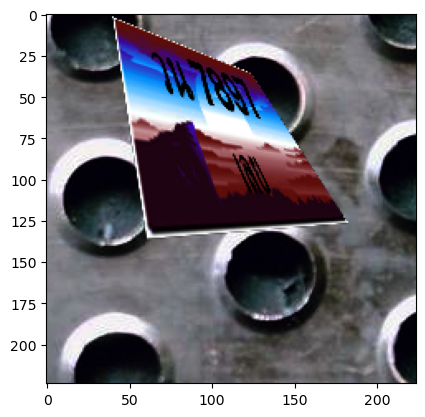

In [67]:
import matplotlib.pyplot as plot
sample = images[1, :, :, :].unsqueeze(dim=0)
plot.imshow(sample.squeeze().numpy().transpose(1, 2, 0))

In [68]:
predict = model(sample)

In [69]:
A4_WIDTH_MM, A4_HEIGHT_MM, dpi = 297, 210, 96
A4_WIDTH_PIXELS = int((A4_WIDTH_MM / 25.4) * dpi)
A4_HEIGHT_PIXELS = int((A4_HEIGHT_MM / 25.4) * dpi)

# Convert the points to a NumPy array
src_pts = np.array(predict.detach().numpy(), dtype=np.float32)
src_pts = src_pts.reshape(4, 2)

# Destination points: A4 corners in pixel space (top-left, top-right, bottom-right, bottom-left)
dst_pts = np.array([
    [0, 0],  # Top-left corner
    [A4_WIDTH_PIXELS - 1, 0],  # Top-right corner
    [A4_WIDTH_PIXELS - 1, A4_HEIGHT_PIXELS - 1],  # Bottom-right corner
    [0, A4_HEIGHT_PIXELS - 1]  # Bottom-left corner
], dtype=np.float32)

H = find_homography(src_pts, dst_pts)
print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 7.95875783e+00 -1.22218382e+00 -3.18762228e+02]
 [-4.18522718e+00  1.03517764e+01  1.38189213e+02]
 [-5.72099431e-03  7.24283038e-03  1.00000000e+00]]


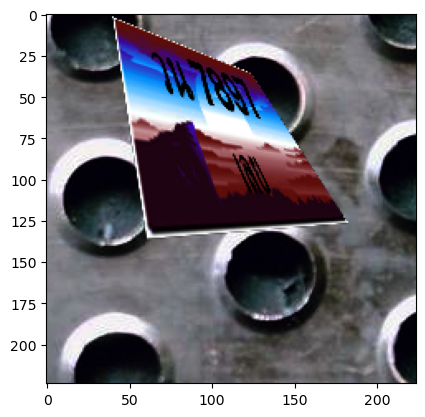

In [70]:
plot.imshow(sample.squeeze().numpy().transpose(1, 2, 0))

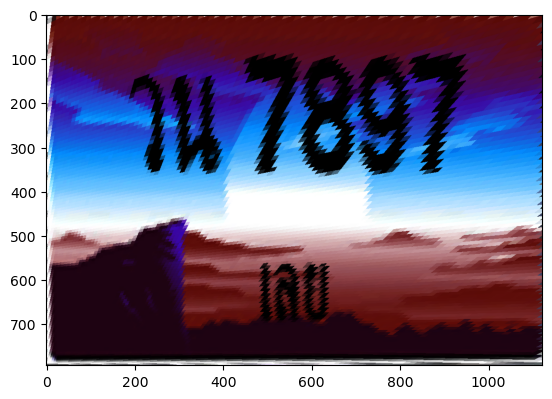

In [71]:
warped_image = warpPerspective(sample.squeeze().numpy().transpose(1, 2, 0), H, (A4_HEIGHT_PIXELS, A4_WIDTH_PIXELS,))
plot.imshow(warped_image)

In [58]:
images, labels = next(iter(test_loader))

In [59]:
import torchvision

save_dir = '/mnt/c/Users/teraw/Developer/demo_samples'

for i in range(images.size(0)):
    torchvision.utils.save_image(images[i].numpy().transpose(1, 2, 0), os.path.join(save_dir, f'image_{i}.png'))